# Systematic Mitigation from Overlapping Surveys

In this notebook, I explore some ideas presented in my "systemtaic mitigation" notes with some simple toy-models. Due to that linear Ordinary Least Square (OLS) regression assumes that the underlying signal must be Gaussian and independently identically distributed (i.i.d.) in the basis that it is represented, we base our simulations on the Mode Projection (MP) method presented in Weaverdyck and Huterer. 

In [73]:
import healpy as hp
import pyccl as ccl
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
import tqdm
import scipy.optimize as optimize
dpi = 300
plt.rcParams['figure.dpi']= dpi
plt.rc("savefig", dpi=dpi)
plt.rc('font', size=10)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rc('lines', dotted_pattern = [2., 2.])

In [74]:
def MSE(d1,d2,weight=1):
    return np.sum(np.real(weight*(d1-d2)*np.conjugate(d1-d2)))/np.size(d1)

In [259]:
def MP_map(d,t,ell):
    cl_td = hp.anafast(t,d)
    cl_tt = hp.anafast(t)
    alpha = np.sum((2*ell+1)[2:]*cl_td[2:]/s[2:])/np.sum((2*ell+1)[2:]*cl_tt[2:]/s[2:])
    return alpha

def residual(alpha, T, d, weight):
    fit = np.dot(T,alpha.reshape(-1,1))
    return np.sum(np.real((fit.reshape(-1)-d)*np.conjugate(fit.reshape(-1)-d))*weight)

def joint_residual(alpha, T1, T2, d1, d2, weight):
    alpha1 = alpha[:int(len(alpha)/2)]
    alpha2 = alpha[int(len(alpha)/2):]
    fit1 = np.dot(T1,alpha1.reshape(-1,1)).reshape(-1)
    fit2 = np.dot(T2,alpha2.reshape(-1,1)).reshape(-1)
    res1 = np.sum(np.real((fit1-d1)*np.conjugate(fit1-d1))*weight)
    res2 = np.sum(np.real((fit1-d1)*np.conjugate(fit1-d1))*weight)
    res12 = np.sum(np.real(((fit1-d1)-(fit2-d2))*np.conjugate((fit1-d1)-(fit2-d2)))*weight)
    return 0.1*res1+0.1*res2+10*res12

def MP_alm(d,t_arr,ell):
    n = len(t_arr)
    sigma_td = np.zeros((n,1))
    sigma_tt = np.zeros((n,n))
    for i,t1 in enumerate(t_arr):
        for j,t2 in enumerate(t_arr):
            sigma_tt[i,j] = np.sum((2*ell+1)[2:]*hp.alm2cl(t1,t2)[2:]/s[2:])
        sigma_td[i,0] = np.sum((2*ell+1)[2:]*hp.alm2cl(t1,d)[2:]/s[2:])
    alpha = np.dot(np.linalg.inv(sigma_tt),sigma_td)
    return alpha.reshape(n)

def TS_alm(d,t_arr,ell):
    n = len(t_arr)
    alpha = [np.zeros(n) for _ in range(2)]
    cl_td = np.zeros((n,1,len(ell)))
    cl_tt = np.zeros((n,n,len(ell)))
    for i,t1 in enumerate(t_arr):
        for j,t2 in enumerate(t_arr):
            cl_tt[i,j,:] = hp.alm2cl(t1,t2)
        cl_td[i,0,:] = hp.alm2cl(t1,d)
    for l in ell[2:]:
        #print(l)
        tt = cl_tt[:,:,l]
        td = cl_td[:,:,l]
        alph = np.dot(np.linalg.inv(tt),td)
        alpha.append(alph.reshape(-1))
    return np.array(alpha).T

In [353]:
talm0 = hp.synalm(t0)
talm1 = hp.synalm(t1)
talm2 = hp.synalm(t2)
talm_add = 0.2*hp.synalm(t0)

dalm = salm+talm0+talm1+talm2+talm_add

t_arr = np.array([talm0+0.1*hp.synalm(t0),talm1+0.*hp.synalm(t0),talm2+0.*hp.synalm(t1)])

In [354]:
alpha = TS_alm(dalm-salm,t_arr,ell)
shat = dalm.copy()
for i in range(len(alpha)):
    shat -= hp.almxfl(t_arr[i],alpha[i])
shatmap = hp.alm2map(shat,nside)
np.sqrt(MSE(shatmap,smap))

0.06835300099484402

In [355]:
alpha = MP_alm(dalm-salm,t_arr,ell)
shat = dalm.copy() 
shat -= np.dot(alpha,t_arr)
shatmap = hp.alm2map(shat,nside)
np.sqrt(MSE(shatmap,smap))

0.0684938810378862

In [76]:
nside = 256
lmax = 3*nside

We generate data vector using the first redshift bin forecasted for LSST Y1. For now, we use three simple templates for contamination: 
- $C_\ell^{tt}\propto(\ell+1)^0$
- $C_\ell^{tt}\propto(\ell+1)^{-1}$
- $C_\ell^{tt}\propto(\ell+1)^{-2}$

The $C_\ell$ of each template is shown in the plot below.

In [121]:
cl_camb = np.load('cl_camb_nonlin_Y1.npy',allow_pickle=True).item()
ell = np.arange(0,lmax)
s = cl_camb['W1xW1'][0:lmax]*2*np.pi/(ell*(ell+1))
s[0] = 0

/tmp/ipykernel_23809/149604723.py:3: RuntimeWarning: invalid value encountered in true_divide
  s = cl_camb['W1xW1'][0:lmax]*2*np.pi/(ell*(ell+1))


In [280]:
t0 = np.ones_like(ell)*2e-6
t0[:2] = 0
t1 = 5e-5/(ell+1)
t1[:2] = 0
t2 = 5e-4/(ell+1)**2
t2[:2] = 0

Text(0.5, 1.0, 'Signal and Templates')

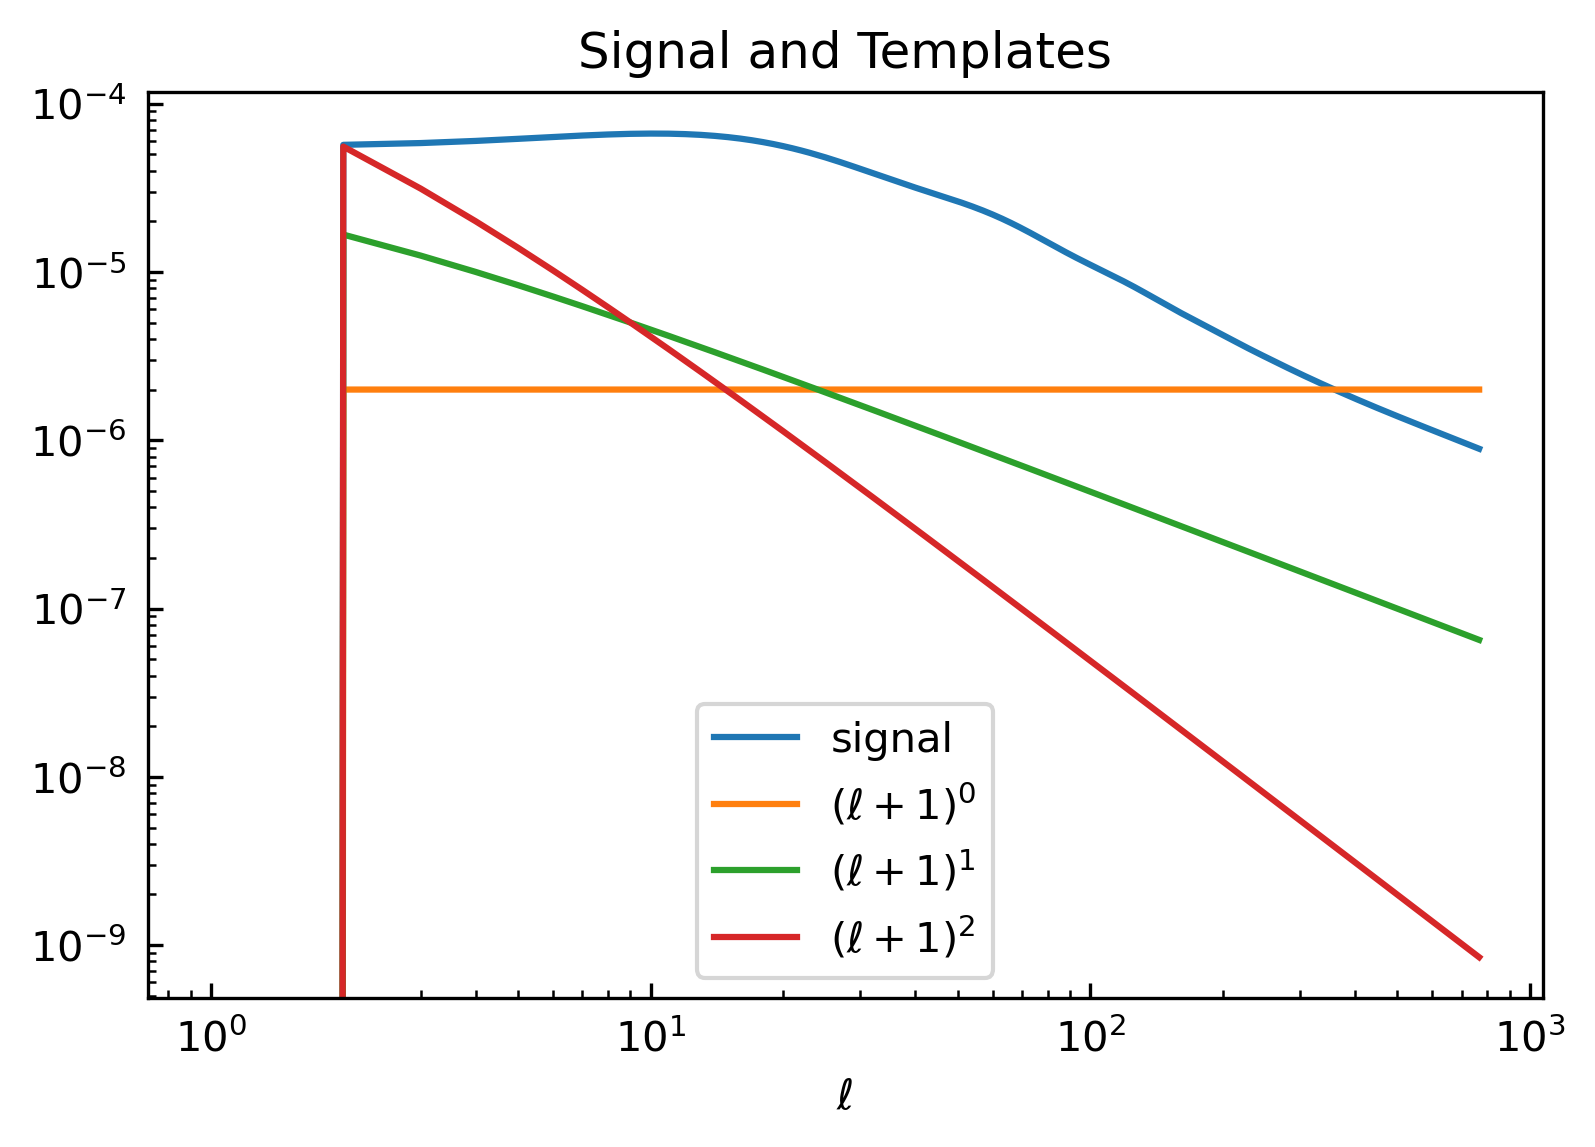

In [232]:
plt.loglog(ell,s,label='signal')
plt.loglog(ell,t0,label=r'$(\ell+1)^0$')
plt.loglog(ell,t1,label=r'$(\ell+1)^1$')
plt.loglog(ell,t2,label=r'$(\ell+1)^2$')
plt.legend()
plt.xlabel(r'$\ell$')
plt.title('Signal and Templates')

In [ ]:
rmse1_0 = []
rmse2_0 = []
rmse_0 = []

rmse1 = []
rmse2 = []
rmse = []

#salm = np.load('Y1map/bin5.npy')
#smap = hp.alm2map(salm,nside)
for _ in tqdm.trange(100):
    np.random.seed(_)

    salm = hp.synalm(s)
    smap = hp.alm2map(salm,nside)
    #s = hp.alm2cl(salm)
    
    corralm = hp.synalm(t1)

    talm1_0 = hp.synalm(t0)
    talm1_1 = hp.synalm(t1)+corralm
    talm1_2 = hp.synalm(t2)#+1e6*hp.almxfl(salm,t2)

    talm2_0 = hp.synalm(t0)
    talm2_1 = hp.synalm(t1)+corralm #+1e6*hp.almxfl(salm,t1)
    talm2_2 = hp.synalm(t2)

    talm_comm1 = hp.synalm(t0)
    talm_comm2 = hp.synalm(t1)


    talms1 = np.array([talm1_0+0.01*hp.synalm(t0),talm1_1+0.01*hp.synalm(t0),talm1_2+0.01*hp.synalm(t0)]+[hp.synalm(t1) for _ in range(10)])
    talms2 = np.array([talm2_0+0.01*hp.synalm(t0),talm2_1+0.01*hp.synalm(t0),talm2_2+0.01*hp.synalm(t0)]+[hp.synalm(t1) for _ in range(10)])
    talm_comms = np.array([talm_comm1, talm_comm2])
    
    
    dalm1 = salm+0.3*talm_comm1+0.4*talm_comm2+0.2*talm1_0+0.5*talm1_1+3*talm1_2+hp.synalm(2e-7*np.ones_like(ell))+0.2*hp.synalm(t1)
    dalm2 = salm+0.2*talm_comm2+0.5*talm_comm2+0.4*talm2_0+0.3*talm2_1+1*talm2_2+hp.synalm(2e-7*np.ones_like(ell))+0.3*hp.synalm(t2)
    alpha1 = MP_alm(dalm1,np.concatenate((talms1,talm_comms)),ell)
    alpha2 = MP_alm(dalm2,np.concatenate((talms2,talm_comms)),ell)

    shat1 = dalm1 - np.dot(alpha1,np.concatenate((talms1,talm_comms)))
    shat2 = dalm2 - np.dot(alpha2,np.concatenate((talms2,talm_comms)))
    shatmap1 = hp.alm2map(shat1,nside)
    shatmap2 = hp.alm2map(shat2,nside)

    cov = np.cov(shatmap1,shatmap2)
    w1_0 = 1/(cov[0,0]-1*cov[1,0])
    w2_0 = 1/(cov[1,1]-1*cov[1,0])
    w1 = np.sort([0,w1_0/(w1_0+w2_0),1])[1]
    w2 = np.sort([0,w2_0/(w1_0+w2_0),1])[1]
    shatmap = w1*shatmap1+w2*shatmap2
    
    rmse1_0.append(np.sqrt(MSE(shatmap1,smap)))
    rmse2_0.append(np.sqrt(MSE(shatmap2,smap)))
    rmse_0.append(np.sqrt(MSE(shatmap,smap)))
    
    
    
    alpha = MP_alm(dalm1-dalm2,np.concatenate((talms1,talms2)),ell)

    dalm_mp1 = dalm1 - np.dot(alpha[:len(talms1)],talms1)
    dalm_mp2 = dalm2 + np.dot(alpha[len(talms1):],talms2)

    alpha1 = MP_alm(dalm_mp1,talm_comms,ell)
    alpha2 = MP_alm(dalm_mp2,talm_comms,ell)

    shat1 = dalm_mp1 - np.dot(alpha1,talm_comms)
    shat2 = dalm_mp2 - np.dot(alpha2,talm_comms)

    shatmap1 = hp.alm2map(shat1,nside)
    shatmap2 = hp.alm2map(shat2,nside)

    cov = np.cov(shatmap1,shatmap2)
    w1_0 = 1/(cov[0,0]-1*cov[1,0])
    w2_0 = 1/(cov[1,1]-1*cov[1,0])
    w1 = np.sort([0,w1_0/(w1_0+w2_0),1])[1]
    w2 = np.sort([0,w2_0/(w1_0+w2_0),1])[1]
    shatmap = w1*shatmap1+w2*shatmap2

    rmse1.append(np.sqrt(MSE(shatmap1,smap)))
    rmse2.append(np.sqrt(MSE(shatmap2,smap)))
    rmse.append(np.sqrt(MSE(shatmap,smap)))

In [129]:
np.mean(rmse1_0), np.mean(rmse1)

(0.10034545367583358, 0.0981436245381992)

In [400]:
mses = []
for _ in tqdm.trange(10):
    np.random.seed(_)
    talm1_0 = hp.synalm(t0)
    talm2_0 = hp.synalm(t0)
    salm = hp.synalm(s)
    alpha1 = MP_alm(salm,[talm1_0],ell)
    alpha2 = MP_alm(salm,[talm2_0],ell)
    shat1 = salm - alpha1*talm1_0
    shat2 = salm - alpha2*talm2_0
    shatmap1 = hp.alm2map(shat1,nside)
    shatmap2 = hp.alm2map(shat2,nside)
    mses.append(MSE(shatmap1,shatmap2))

100%|██████████| 10/10 [00:02<00:00,  4.18it/s]


In [413]:
mses

[8.006176043524282e-08,
 7.162236838120557e-09,
 2.53203137441687e-09,
 9.264631123695634e-08,
 2.4850120010055625e-07,
 7.34277661698453e-08,
 2.5350034040452515e-07,
 5.106758783462968e-08,
 5.796384069512122e-07,
 8.522423372796776e-08]

In [412]:
talm1_0 = hp.synalm(t0)
talm2_0 = hp.synalm(t0)
talm3 = 0.02*hp.synalm(t0)
smap = hp.alm2map(salm,nside)
alpha1 = MP_alm(salm+talm1_0+talm3,[talm1_0],ell)
alpha2 = MP_alm(salm+talm2_0,[talm2_0],ell)
shat1 = hp.alm2map(salm+talm1_0+talm3-alpha1*talm1_0,nside)
shat2 = hp.alm2map(salm+talm2_0-alpha2*talm2_0,nside)
MSE(shat1,smap), MSE(shat2,smap)
MSE(shat1,shat2)

3.764573776728211e-05

In [410]:
np.std(hp.alm2map(talm3,nside))/np.std(hp.alm2map(salm+talm1_0,nside))

0.014024049203650472

In [395]:
alpha1, alpha2

(array([0.99967879]), array([1.00110167]))

In [378]:
salm = hp.synalm(s)
smap = hp.alm2map(salm,nside)
#s = hp.alm2cl(salm)

corralm = hp.synalm(t1)

talm1_0 = hp.synalm(t0)
talm1_1 = hp.synalm(t1)+corralm
talm1_2 = hp.synalm(t2)#+1e6*hp.almxfl(salm,t2)

talm2_0 = hp.synalm(t0)
talm2_1 = hp.synalm(t1)+corralm #+1e6*hp.almxfl(salm,t1)
talm2_2 = hp.synalm(t2)

talm_comm1 = hp.synalm(t0)
talm_comm2 = hp.synalm(t1)


talms1 = np.array([talm1_0+0.5*hp.synalm(t0),talm1_1+0.5*hp.synalm(t0),talm1_2+0.5*hp.synalm(t0)]+[hp.synalm(t1) for _ in range(10)])
talms2 = np.array([talm2_0+0.5*hp.synalm(t0),talm2_1+0.5*hp.synalm(t0),talm2_2+0.5*hp.synalm(t0)]+[hp.synalm(t1) for _ in range(10)])
talm_comms = np.array([talm_comm1, talm_comm2])

In [372]:
dalm1 = salm+0.2*talm_comm1+0.4*talm_comm2+0.2*talm1_0+0.5*talm1_1+3*talm1_2+hp.synalm(2e-7*np.ones_like(ell))+0.2*hp.synalm(t1)+talm_corr
dalm2 = salm+0.2*talm_comm2+0.5*talm_comm2+0.4*talm2_0+0.3*talm2_1+1*talm2_2+hp.synalm(2e-7*np.ones_like(ell))+0.3*hp.synalm(t2)+talm_corr
dmap1 = hp.alm2map(dalm1,nside)
alpha1 = MP_alm(dalm1,np.concatenate((talms1,talm_comms)),ell)
alpha2 = MP_alm(dalm2,np.concatenate((talms2,talm_comms)),ell)

shat1 = dalm1 - np.dot(alpha1,np.concatenate((talms1,talm_comms)))
shat2 = dalm2 - np.dot(alpha2,np.concatenate((talms2,talm_comms)))
shatmap1 = hp.alm2map(shat1,nside)
shatmap2 = hp.alm2map(shat2,nside)

cov = np.cov(shatmap1,shatmap2)
w1_0 = 1/(cov[0,0]-1*cov[1,0])
w2_0 = 1/(cov[1,1]-1*cov[1,0])
w1 = np.sort([0,w1_0/(w1_0+w2_0),1])[1]
w2 = np.sort([0,w2_0/(w1_0+w2_0),1])[1]
shatmap = w1*shatmap1+w2*shatmap2
#print(alpha1,alpha2)
np.sqrt(MSE(shatmap1,smap)), np.sqrt(MSE(shatmap2,smap)), np.sqrt(MSE(shatmap,smap)), np.sqrt(MSE(dmap1,smap))

(0.14992474836492847,
 0.14020354909217153,
 0.11714765624642942,
 0.1769225264416096)

In [373]:
alpha = MP_alm(dalm1-dalm2,np.concatenate((talms1,talms2)),ell)

dalm_mp1 = dalm1 - np.dot(alpha[:len(talms1)],talms1)
dalm_mp2 = dalm2 + np.dot(alpha[len(talms1):],talms2)

alpha1 = MP_alm(dalm_mp1,talm_comms,ell)
alpha2 = MP_alm(dalm_mp2,talm_comms,ell)

shat1 = dalm_mp1 - np.dot(alpha1,talm_comms)
shat2 = dalm_mp2 - np.dot(alpha2,talm_comms)

shatmap1 = hp.alm2map(shat1,nside)
shatmap2 = hp.alm2map(shat2,nside)

cov = np.cov(shatmap1,shatmap2)
w1_0 = 1/(cov[0,0]-1*cov[1,0])
w2_0 = 1/(cov[1,1]-1*cov[1,0])
w1 = np.sort([0,w1_0/(w1_0+w2_0),1])[1]
w2 = np.sort([0,w2_0/(w1_0+w2_0),1])[1]
shatmap = w1*shatmap1+w2*shatmap2

np.sqrt(MSE(shatmap1,smap)), np.sqrt(MSE(shatmap2,smap)), np.sqrt(MSE(shatmap,smap))

(0.15039617672809005, 0.14089387680902457, 0.11791350020916774)

In [374]:
alpha = TS_alm(dalm1-dalm2,np.concatenate((talms1,talms2)),ell)

alpha1 = alpha[:len(talms1)]
alpha2 = alpha[len(talms2):]

shat1 = dalm1.copy()
for i in range(len(alpha1)):
    shat1 -= hp.almxfl(talms1[i],alpha1[i])
    
shat2 = dalm2.copy()
for i in range(len(alpha2)):
    shat2 += hp.almxfl(talms2[i],alpha2[i])

alpha1 = MP_alm(shat1,talm_comms,ell)
alpha2 = MP_alm(shat2,talm_comms,ell)

shat1 = shat1 - np.dot(alpha1,talm_comms)
shat2 = shat2 - np.dot(alpha2,talm_comms)

shatmap1 = hp.alm2map(shat1,nside)
shatmap2 = hp.alm2map(shat2,nside)

cov = np.cov(shatmap1,shatmap2)
w1_0 = 1/(cov[0,0]-1*cov[1,0])
w2_0 = 1/(cov[1,1]-1*cov[1,0])
w1 = np.sort([0,w1_0/(w1_0+w2_0),1])[1]
w2 = np.sort([0,w2_0/(w1_0+w2_0),1])[1]
shatmap = w1*shatmap1+w2*shatmap2

np.sqrt(MSE(shatmap1,smap)), np.sqrt(MSE(shatmap2,smap)), np.sqrt(MSE(shatmap,smap))

(2.9408165644009925, 4.4505327797467755, 2.9408165644009925)

## Orthogonal projection

In [141]:
def gramschmidt(vlist,elist=[]):
    if len(vlist) == 0:
        return elist
    else:
        vec = vlist[0]
        for e in elist:
            vec = vec-np.dot(vec,e)*e
        vec = vec/np.sqrt(np.dot(vec,vec))
        elist.append(vec)
        vlist = vlist[1:]
        return gramschmidt(vlist,elist)

In [142]:
tmap1_3 = hp.synfast(t0,nside)
talm1_3 = hp.map2alm(tmap1_3)
tmap1_4 = hp.synfast(t1,nside)
talm1_4 = hp.map2alm(tmap1_4)
tmap1_5 = hp.synfast(t2,nside)
talm1_5 = hp.map2alm(tmap1_5)

tmap2_3 = hp.synfast(t0,nside)
talm2_3 = hp.map2alm(tmap2_3)
tmap2_4 = hp.synfast(t1,nside)
talm2_4 = hp.map2alm(tmap2_4)
tmap2_5 = hp.synfast(t2,nside)
talm2_5 = hp.map2alm(tmap2_5)

In [143]:
dmap_op1 = smap+0.2*tmap1_0+0.5*tmap1_1+3*tmap1_2+hp.synfast(2e-7*np.ones_like(ell),nside)+0.2*hp.synfast(t1,nside)+tmap_corr

t1_list = [tmap1_0, tmap1_1, tmap1_2, tmap1_3, tmap1_4, tmap1_5]
t1_add = [hp.synfast(t0,nside)+0.05*smap for i in range(10)]

# firs orthogonal projection the different templates
vlist = t1_list+t1_add
elist = gramschmidt(vlist,elist=[])
transform = np.zeros((len(vlist),len(vlist)))
for i in range(len(vlist)):
    for j in range(len(elist)):
        transform[i][j] = np.dot(elist[i],vlist[j])
        
clist = [np.dot(e,dmap_op1) for e in elist]
coeff = np.dot(np.linalg.inv(transform),clist)

shat1 = dmap_op1 - np.dot(coeff,np.array(t1_list+t1_add))


print(np.sqrt(MSE(shat1,smap)))

0.13494675990976518


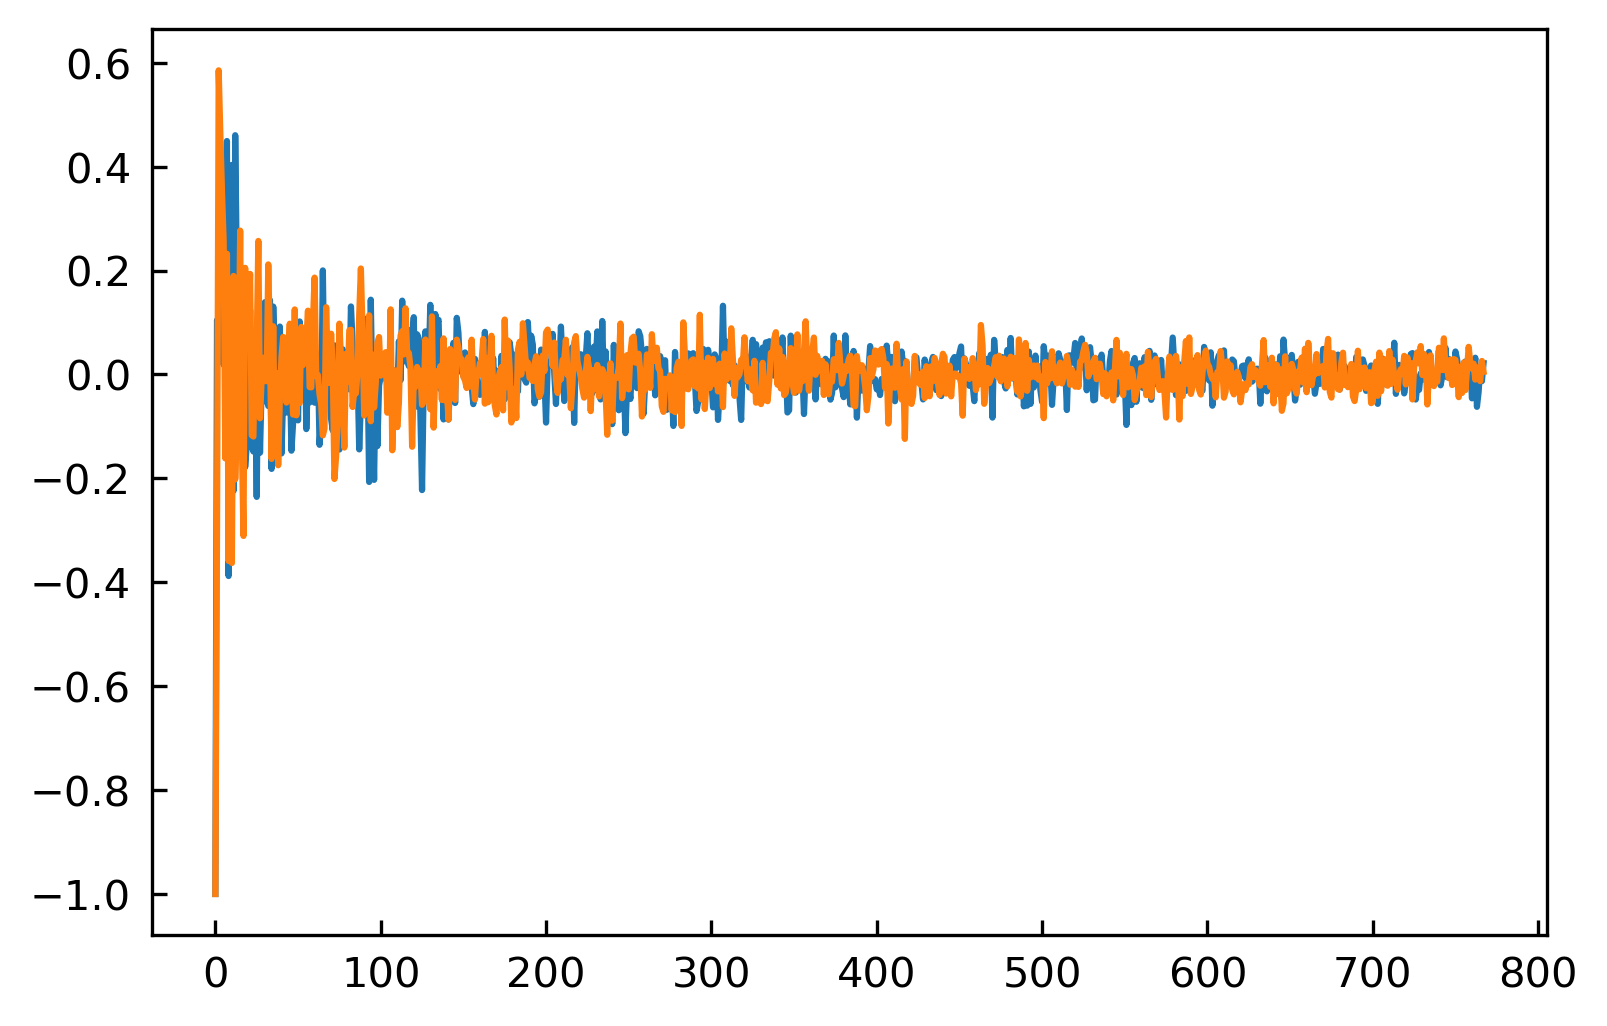

In [62]:
plt.plot(ell,hp.alm2cl(talm1_2,salm)/np.sqrt(hp.alm2cl(talm1_2)*hp.alm2cl(salm)))
plt.plot(ell,hp.alm2cl(talm2_1,salm)/np.sqrt(hp.alm2cl(talm2_1)*hp.alm2cl(salm)))
#plt.ylim(-5e-8,5e-8)

In [68]:
# first remove the common templates by OLS
dmap1 = smap+0.2*tmap_comm1+1.2*tmap_comm2+0.2*tmap1_0+0.5*tmap1_1+3*tmap1_2+hp.synfast(2e-7*np.ones_like(ell),nside)+0.2*hp.synfast(t1,nside)+tmap_corr
dmap2 = smap+0.2*tmap_comm1+1.2*tmap_comm2+0.4*tmap2_0+0.3*tmap2_1+1*tmap2_2+hp.synfast(2e-7*np.ones_like(ell),nside)+0.2*hp.synfast(t1,nside)+tmap_corr

dalm1 = hp.map2alm(dmap1)
dalm2 = hp.map2alm(dmap2)

alpha1 = MP_alm(dalm1,talm_comms,ell)
alpha2 = MP_alm(dalm2,talm_comms,ell)
print(alpha1,alpha2)

dalm_op1 = dalm1 - np.dot(alpha1,talm_comms)
dalm_op2 = dalm2 - np.dot(alpha2,talm_comms)
dmap_op1 = hp.alm2map(dalm_op1,nside)
dmap_op2 = hp.alm2map(dalm_op2,nside)

# Orthogonal projection for the rest
vlist = [tmap1_0, tmap1_1, tmap1_2, tmap1_3, tmap1_4, tmap1_5,
         tmap2_0, tmap2_1, tmap2_2, tmap2_3, tmap2_4, tmap2_5]
elist = gramschmidt(vlist,elist=[])
transform = np.zeros((len(vlist),len(vlist)))
for i in range(len(vlist)):
    for j in range(len(elist)):
        transform[i][j] = np.dot(elist[i],vlist[j])
        
clist = [np.dot(e,dmap_op1-dmap_op2) for e in elist]
coeff = np.dot(np.linalg.inv(transform),clist)

shat1 = dmap_op1 - coeff[0]*tmap1_0  - coeff[1]*tmap1_1 - coeff[2]*tmap1_2\
        - coeff[3]*tmap1_3 - coeff[4]*tmap1_4 - coeff[5]*tmap1_5
shat2 = dmap_op2 + coeff[6]*tmap2_0  + coeff[7]*tmap2_1 + coeff[8]*tmap2_2\
        - coeff[9]*tmap2_3 - coeff[10]*tmap2_4 - coeff[11]*tmap2_5

cov = np.cov(shatmap1,shatmap2)
w1_0 = 1/(cov[0,0]-1*cov[1,0])
w2_0 = 1/(cov[1,1]-1*cov[1,0])
w1 = np.sort([0,w1_0/(w1_0+w2_0),1])[1]
w2 = np.sort([0,w2_0/(w1_0+w2_0),1])[1]
shatmap = w1*shat1+w2*shat2

[0.19590118 1.17362769] [0.19626373 1.16767006]


In [69]:
np.sqrt(MSE(shat1,smap)), np.sqrt(MSE(shat2,smap)), np.sqrt(MSE(shatmap,smap))

(0.12913116573806716, 0.12980082175014815, 0.10934790233618893)

In [72]:
dmap_op1 = smap+\
            0.2*tmap1_0+0.5*tmap1_1+3*tmap1_2+hp.synfast(2e-7*np.ones_like(ell),nside)+0.2*hp.synfast(t1,nside)+tmap_corr+\
            0.0*tmap_comm1+0.0*tmap_comm2
dmap_op2 = smap+\
            0.4*tmap2_0+0.3*tmap2_1+1*tmap2_2+hp.synfast(2e-7*np.ones_like(ell),nside)+0.2*hp.synfast(t1,nside)+tmap_corr+\
            0.0*tmap_comm1+0.0*tmap_comm2

t1_list = [tmap1_0, tmap1_1, tmap1_2, tmap1_3, tmap1_4, tmap1_5]
t2_list = [tmap2_0, tmap2_1, tmap2_2, tmap2_3, tmap2_4, tmap2_5]
t1_add = [hp.synfast(t0,nside)+0.05*smap for i in range(10)]
t2_add = [hp.synfast(t0,nside)+0.05*smap for i in range(10)]

# firs orthogonal projection the different templates
vlist = t1_list+t1_add+t2_list+t2_add
elist = gramschmidt(vlist,elist=[])
transform = np.zeros((len(vlist),len(vlist)))
for i in range(len(vlist)):
    for j in range(len(elist)):
        transform[i][j] = np.dot(elist[i],vlist[j])
        
clist = [np.dot(e,dmap_op1-dmap_op2) for e in elist]
coeff = np.dot(np.linalg.inv(transform),clist)

shat1 = dmap_op1 - np.dot(coeff[:len(t1_list+t1_add)],np.array(t1_list+t1_add))
shat2 = dmap_op2 + np.dot(coeff[len(t2_list+t2_add):],np.array(t2_list+t2_add))

print(np.sqrt(MSE(shat1,smap)),np.sqrt(MSE(shat2,smap)))

# remove the common templates by OLS
dalm1 = hp.map2alm(shat1)
dalm2 = hp.map2alm(shat2)

alpha1 = MP_alm(dalm1,talm_comms,ell)
alpha2 = MP_alm(dalm2,talm_comms,ell)
print(alpha1,alpha2)

dalm_op1 = dalm1 - np.dot(alpha1,talm_comms)
dalm_op2 = dalm2 - np.dot(alpha2,talm_comms)
shat1 = hp.alm2map(dalm_op1,nside)
shat2 = hp.alm2map(dalm_op2,nside)

cov = np.cov(shat1,shat2)
w1_0 = 1/(cov[0,0]-1*cov[1,0])
w2_0 = 1/(cov[1,1]-1*cov[1,0])
w1 = np.sort([0,w1_0/(w1_0+w2_0),1])[1]
w2 = np.sort([0,w2_0/(w1_0+w2_0),1])[1]
shatmap = w1*shat1+w2*shat2

0.12539437625144778 0.12546905569551464
[ 0.00108359 -0.00040513] [ 0.0010262  -0.00154408]


In [71]:
MSE(shat1,smap), MSE(shat2,smap), MSE(shatmap,smap)

(0.016376573907838088, 0.016337528708744154, 0.01166642251778649)

## Joint loss function

In [701]:
res = optimize.minimize(residual, np.zeros(len(talms1)), args=(talms1.T,dalm1,weight**2),method='Nelder-Mead')
fit1 = np.dot(talms1.T,res.x)
shat1 = dalm1-fit1
shatmap1 = hp.alm2map(shat1,nside)

res = optimize.minimize(residual, np.zeros(len(talms1)), args=(talms2.T,dalm2,weight**2),method='Nelder-Mead')
fit2 = np.dot(talms2.T,res.x)
shat2 = dalm2-fit2
shatmap2 = hp.alm2map(shat2,nside)

cov = np.cov(shatmap1,shatmap2)
w1_0 = 1/(cov[0,0]-1*cov[1,0])
w2_0 = 1/(cov[1,1]-1*cov[1,0])
w1 = np.sort([0,w1_0/(w1_0+w2_0),1])[1]
w2 = np.sort([0,w2_0/(w1_0+w2_0),1])[1]
shatmap = w1*shatmap1+w2*shatmap2
print(w1,w2)

np.sqrt(MSE(shatmap1,smap)), np.sqrt(MSE(shatmap2,smap)), np.sqrt(MSE(shatmap,smap)), np.sqrt(MSE(0.5*(shatmap1+shatmap2),smap))

0.47935164655058415 0.5206483534494158


(0.12127329447240605,
 0.10159237657125525,
 0.08275642994498379,
 0.08324464378863033)

In [698]:
res = optimize.minimize(joint_residual, np.zeros(2*len(talms1)), args=(talms1.T,talms2.T,dalm1,dalm2,weight**2),method='Nelder-Mead')

fit1 = np.dot(talms1.T,res.x[:len(talms1)])
shat1 = dalm1-fit1
shatmap1 = hp.alm2map(shat1,nside)

fit2 = np.dot(talms2.T,res.x[len(talms1):])
shat2 = dalm2-fit2
shatmap2 = hp.alm2map(shat2,nside)

cov = np.cov(shatmap1,shatmap2)
w1_0 = 1/(cov[0,0]-1*cov[1,0])
w2_0 = 1/(cov[1,1]-1*cov[1,0])
w1 = np.sort([0,w1_0/(w1_0+w2_0),1])[1]
w2 = np.sort([0,w2_0/(w1_0+w2_0),1])[1]
print(w1,w2)
shatmap = w1*shatmap1+w2*shatmap2

np.sqrt(MSE(shatmap1,smap)), np.sqrt(MSE(shatmap2,smap)), np.sqrt(MSE(shatmap,smap)), np.sqrt(MSE(0.5*(shatmap1+shatmap2),smap))

0.2683922584503446 0.7316077415496554


(0.14101101646726621,
 0.1262831475788506,
 0.1134342522894434,
 0.11246783109310952)

## Statistical Uncertainty vs. Incomplete Modeling

As I explained in the notes, the estimates for the underlying number density from both surveys may not be *exactly* the same. In this case, we can ask if this is due to the intrinsic statistic uncertainty of our regression method or the modeling is incomplete (e.g. missing templates, failed to capture higher-order-contributions). 

The idea builds on the fact that the residual (the estimated signal) can be predicted only knowing the templates $T$ and the true signal $s$. No observed data $d$ is needed. The estimated signal is given by: $$\hat s=(I-H)s,$$ where $H=T(T^\dagger T)^{-1}T^\dagger$. 

Now suppose that the observed number density $d$ consists of systematics that can be explained by the MP model, $T\alpha$, systematics that cannot be account for, $\epsilon$, (either due to missing templates or higher-order effects), and the true signal $s$. So the observed data of the two surveys are
$$ d_1=T_1\alpha_1+\epsilon_1+s,\quad d_2=T_2\alpha_2+\epsilon_2+s $$
Then the estimated underlying signal for both surveys would be
$$ \hat s_1=(I-H_1)(s+\epsilon_1),\quad \hat s_2=(I-H_2)(s+\epsilon_2). $$
In the limit that $\epsilon_1,\epsilon_2\to0$, the estimated signal should be similar enough. The only difference is due to the difference between $H_1$ and $H_2$, which is the intrinsic statistical uncertainty associated with the OLS regression method. However, if $\epsilon_1$ and/or $\epsilon_2$ are large, then they will make significant difference between $\hat s_1$ and $\hat s_2$. 

To estimate the intrinsic statistical uncertainty, we can generate an ensemble of simulated data vectors (through pyccl, CAMB, etc.) and compute $(I-H_1)s$ and $(I-H_2)s$ and compute the Mean Squared Error (MSE) between them. Hence we obtain a distribution of MSE in the case that the MP model can perfectly explain all systematics. We can then compute the MSE between the estimates of underlying density from the overlapping surveys $\hat s_1$ and $\hat s_2$. If the MSE is inconsistent with the distribution we obtained above, then it means that it is the residual systematics dominates the difference between the estimates.

Here is an implementation for the idea I presented in the notes. We first start by looking at the MSE between the whole $a_{\ell m}$ data vector.

Here we simulate 1000 realizations of $(I-H_1)$ and $(I-H_2)$. This simulates the MSE distribution when only the intrinsic statistical uncertainty dominates.

In [652]:
corr = []
mses = []
for _ in tqdm.trange(1000):
    np.random.seed(_)
    salm = hp.synalm(s)
    sn1 = hp.synalm(2e-7*np.ones_like(ell))
    sn2 = hp.synalm(2e-7*np.ones_like(ell))
    alpha1 = MP_alm(salm+sn1,talms1,ell)
    alpha2 = MP_alm(salm+sn2,talms2,ell)
    shat1 = salm + sn1 - np.dot(alpha1,talms1)
    shat2 = salm + sn2 - np.dot(alpha2,talms2)
    shatmap1 = hp.alm2map(shat1,nside)
    shatmap2 = hp.alm2map(shat2,nside)
    mses.append(MSE(shatmap1,shatmap2))

100%|██████████| 1000/1000 [05:02<00:00,  3.31it/s]


Here we generate some contaminated observations and perform MP mitigation on them. We first make mock observed number densities. Survey 1 has templates proportional to $(\ell+1)^0$ and $(\ell+1)^{-2}$, and survey 2 has templates proportional to $(\ell+1)^0$ and $(\ell+1)^{-1}$. For now, we make an example where all systematics are within first-order and no missing templates. We can see that $\rm{MSE}(\hat s_1,\hat s_2)$ is consistent with the distribution of MSE when statistical uncertainty dominates.

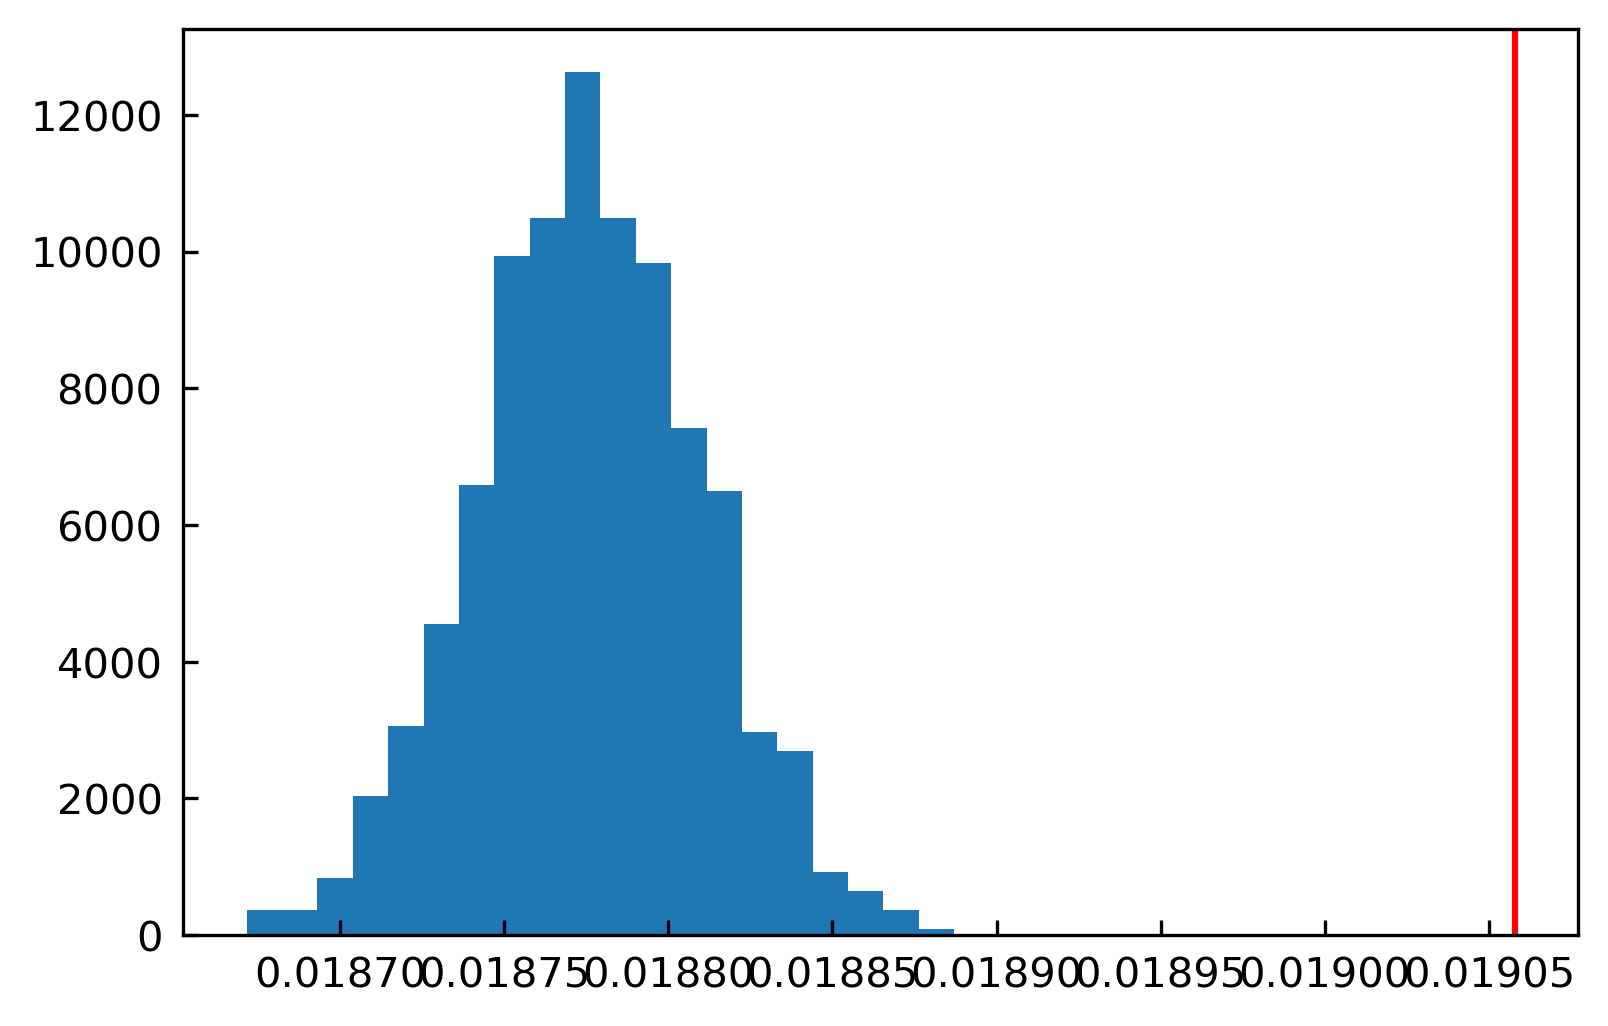

In [653]:
salm = hp.synalm(s)
dalm1 = salm+0.2*talm0+0.5*talm1+3*talm2+hp.synalm(2e-7*np.ones_like(ell))+0.2*hp.synalm(t1)
dalm2 = salm+0.3*talm0+0.3*talm1+1*talm2+hp.synalm(2e-7*np.ones_like(ell))+0.3*hp.synalm(t2)
alpha1 = MP_alm(dalm1,talms1,ell)
alpha2 = MP_alm(dalm2,talms2,ell)

shat1 = dalm1 - np.dot(alpha1,talms1)
shat2 = dalm2 - np.dot(alpha2,talms2)
shatmap1 = hp.alm2map(shat1,nside)
shatmap2 = hp.alm2map(shat2,nside)
mse = MSE(shatmap1,shatmap2)

plt.hist(np.absolute(mses),bins=20,density=True)
plt.axvline(mse,color='red')

In [683]:
smap = hp.alm2map(salm+hp.synalm(2e-7*np.ones_like(ell)),nside)
print(np.std(smap))
sysmap = hp.alm2map(0.3*hp.synalm(t0)+0.3*hp.synalm(t1)+1*hp.synalm(t2),nside)
print(np.var(sysmap))

0.553700813010359
0.009455359174827557


However, if we have a missing templates in one of the surveys, e.g. survey 1 has systematics due to $(\ell+1)^{-1}$ but we do not regress onto it, then we will see an inconsistency between $\text{MSE}(\hat s_1,\hat s_2)$ and the distribution. 

Text(0.5, 1.0, 'MSE missing templates')

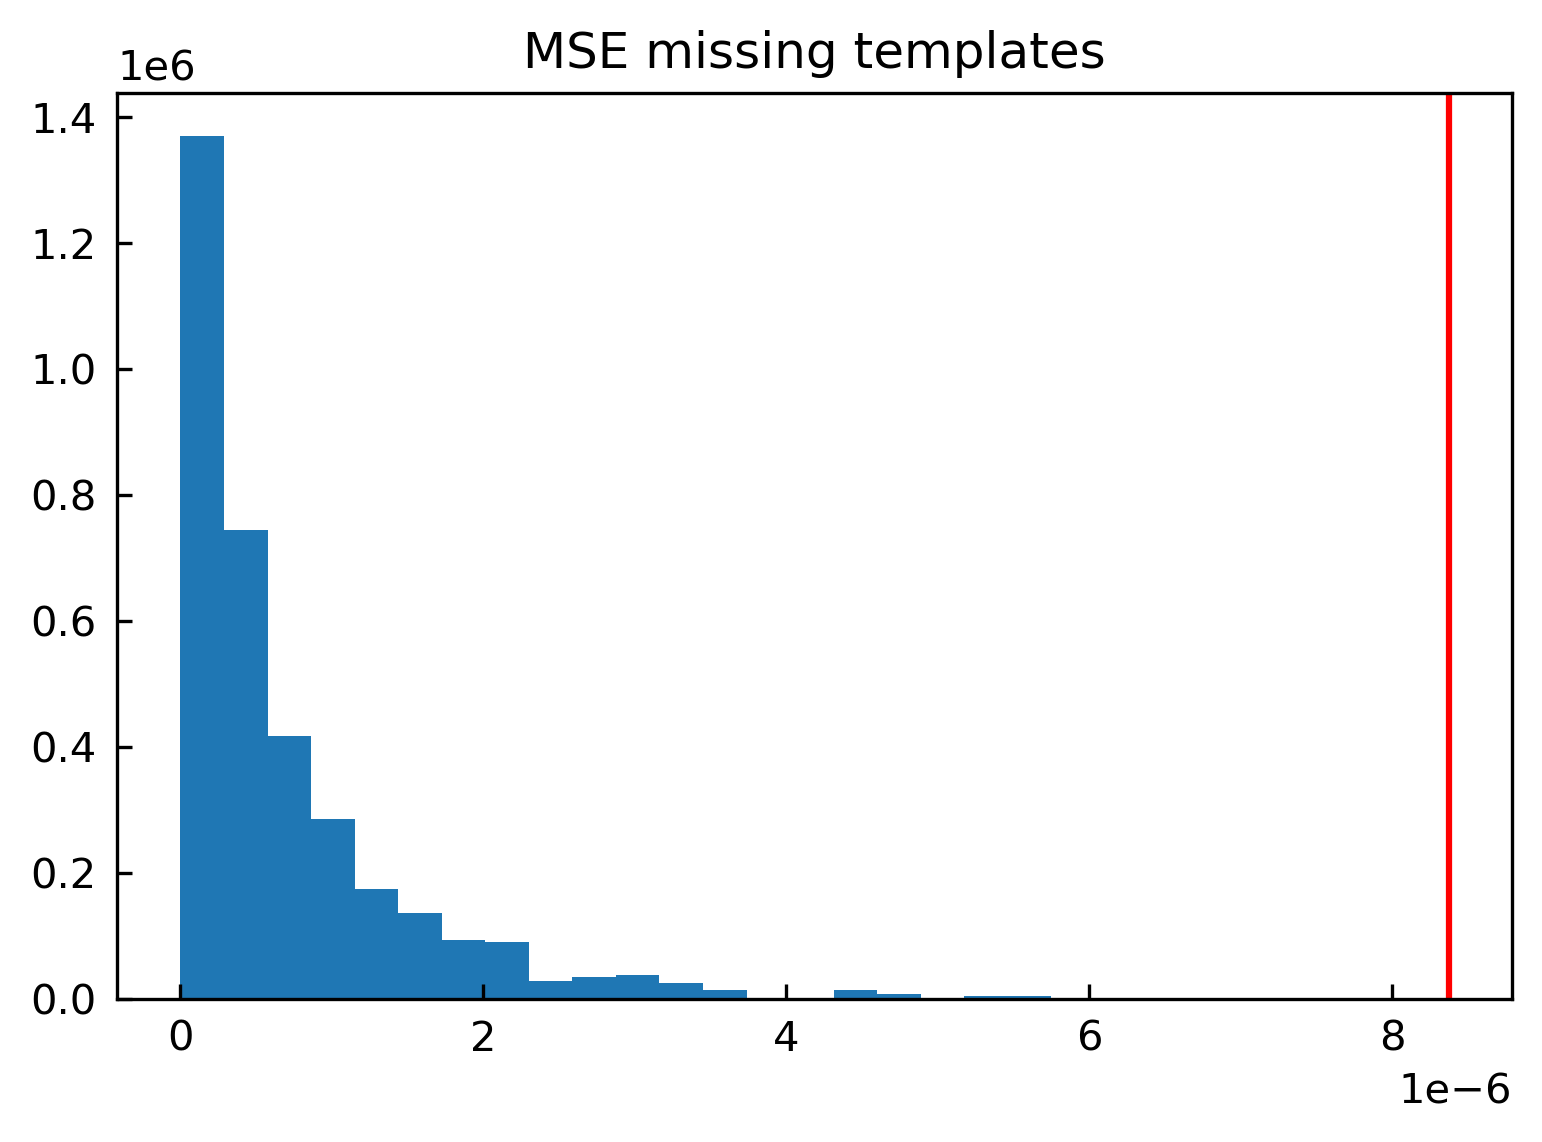

In [16]:
salm = hp.synalm(s)
dalm1 = salm+talm0+talm2+0.01*talm1
dalm2 = salm+talm0+talm1
alpha1 = MP_alm(dalm1,talms1,ell)
alpha2 = MP_alm(dalm2,talms2,ell)

shat1 = dalm1 - np.dot(alpha1,talms1)
shat2 = dalm2 - np.dot(alpha2,talms2)

shatmap1 = hp.alm2map(shat1,nside)
shatmap2 = hp.alm2map(shat2,nside)
mse = MSE(shatmap1,shatmap2)


plt.hist(np.absolute(mses),bins=20,density=True)
plt.axvline(mse,color='red')
plt.title('MSE missing templates')

We could also do this check on each multipole moment. Instead of taking the MSE of the entire $a_{\ell m}$ array, we take look at the $\text{MSE}(\hat a^1_{\ell m},\hat a^2_{\ell m})$ at a given multipole $\ell$. This allows us to determine at which scales the estimated number density is intrinsic statistical uncertainty dominated. One benefit of this exercise is that it allows us to know at which scales the estimates are reliable. E.g. if small $\ell$s are consistent with the intrinsic statistical uncertainty, but not at large $\ell$, then we know that the estimates are reliable for $f_{\rm NL}$ but perhaps not for other analysis.

In [17]:
corr = []
mses = []
l_arr = [0,1,2,3,4,5,6,7,8,9,10,20,40,60,100,200,400]
for _ in tqdm.trange(1000):
    np.random.seed(_)
    salm = hp.synalm(s)
    alpha1 = MP_alm(salm,talms1,ell)
    alpha2 = MP_alm(salm,talms2,ell)
    shat1 = salm - np.dot(alpha1,talms1)
    shat2 = salm - np.dot(alpha2,talms2)
    
    mse = []
    for l in l_arr:
        f = np.zeros(lmax)
        f[l] = 1
        mask = hp.almxfl(shat1,f)!=0
        mse.append(MSE(shat1[mask],shat2[mask]))
    mses.append(mse)
mses = np.array(mses)

100%|██████████| 1000/1000 [02:46<00:00,  6.00it/s]


In [33]:
salm = hp.synalm(s)

dalm1 = salm+talm0+talm2
dalm2 = salm+talm0+talm1

shat1 = dalm1 - np.dot(MP_alm(dalm1,talms1,ell),talms1)
shat2 = dalm2 - np.dot(MP_alm(dalm2,talms2,ell),talms2)

dalm1 = salm+talm0+talm2+0.05*talm1
dalm2 = salm+talm0+talm1

shat1_c = dalm1 - np.dot(MP_alm(dalm1,talms1,ell),talms1)
shat2_c = dalm2 - np.dot(MP_alm(dalm2,talms2,ell),talms2)

In the following, we show this exercise performed at different multipoles. For each multipole, we show an example with perfect mitigation and an example with a missing template.

Text(0.5, 1.0, '$\\ell=$3')

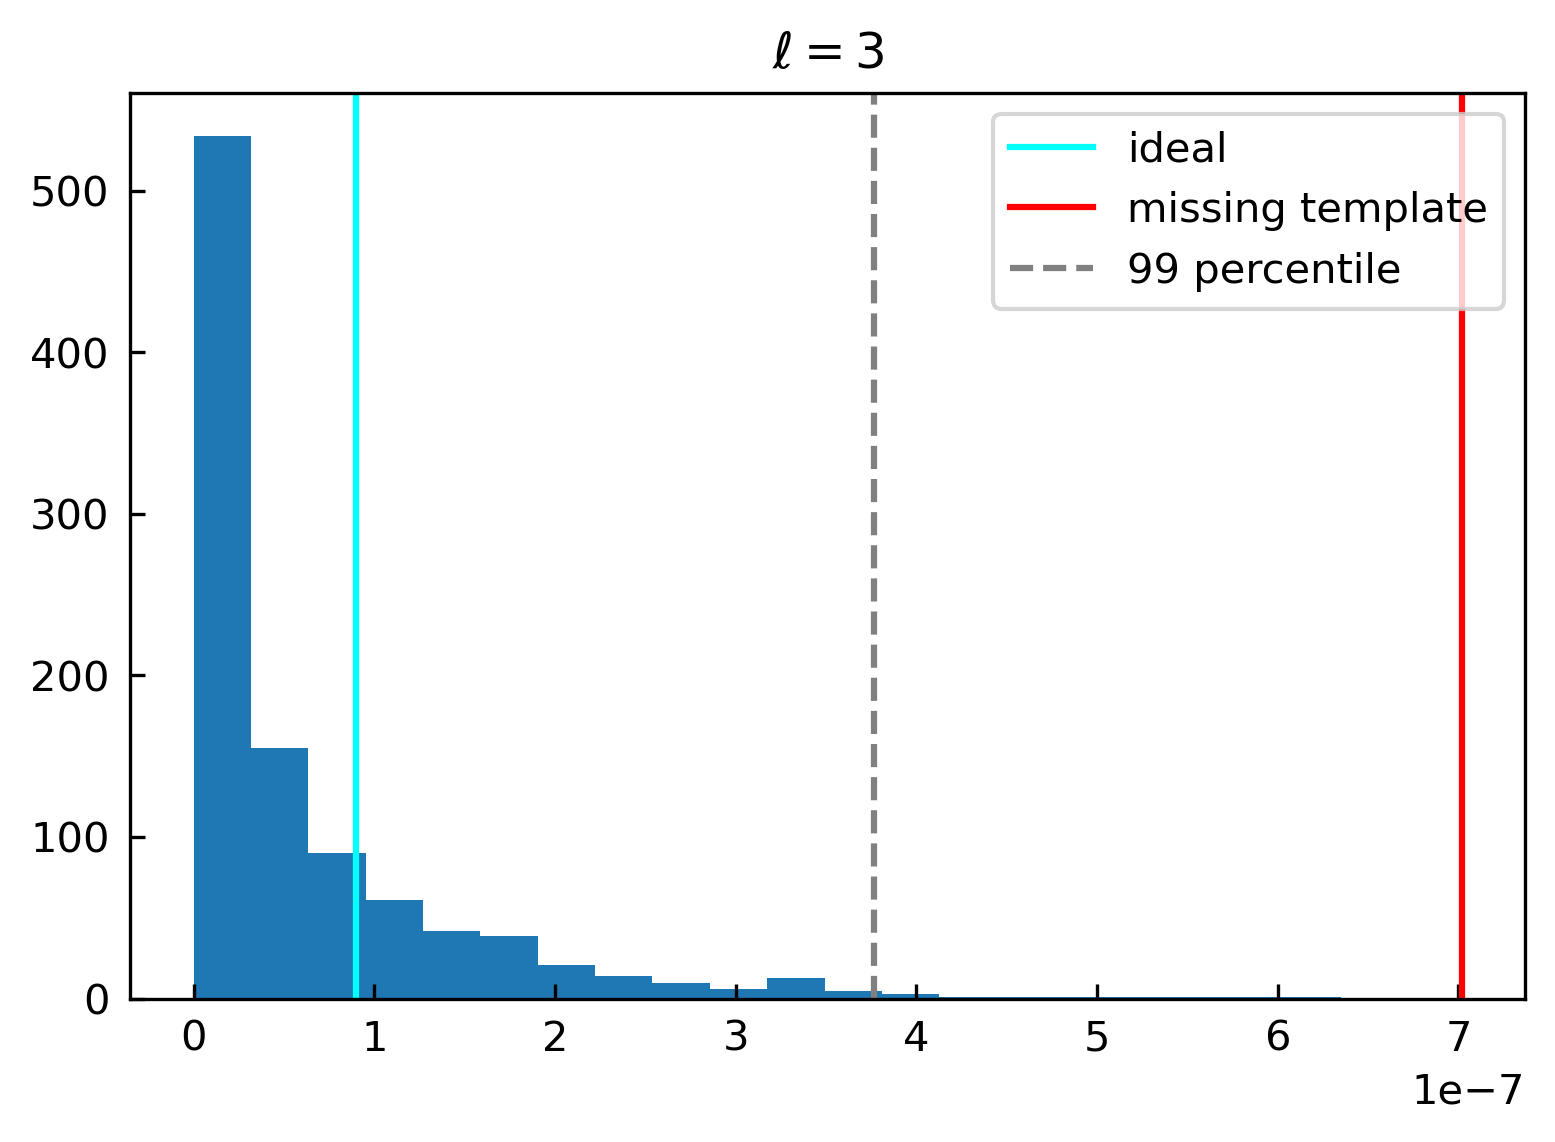

In [34]:
l = 3
li = np.where(np.array(l_arr)==l)[0][0]
_ = plt.hist(mses[:,li],bins=20)
f = np.zeros(lmax)
f[l] = 1
mask = hp.almxfl(shat1,f)!=0

plt.axvline(MSE(shat1[mask],shat2[mask]),color='cyan',label='ideal')
plt.axvline(MSE(shat1_c[mask],shat2_c[mask]),color='red',label='missing template')
plt.axvline(np.percentile(mses[:,li],99),ls='--',color='grey',label='99 percentile')
plt.legend()
plt.title(r'$\ell=$'+str(l))

We see that this test is much more sensitive to residual systematics for higher $\ell$s than lower $\ell$s. I think this might be the result of cosmic variance (we have less data points of $a_{\ell m}$s at low $\ell$). This effect exists in other OLS regression as well. 

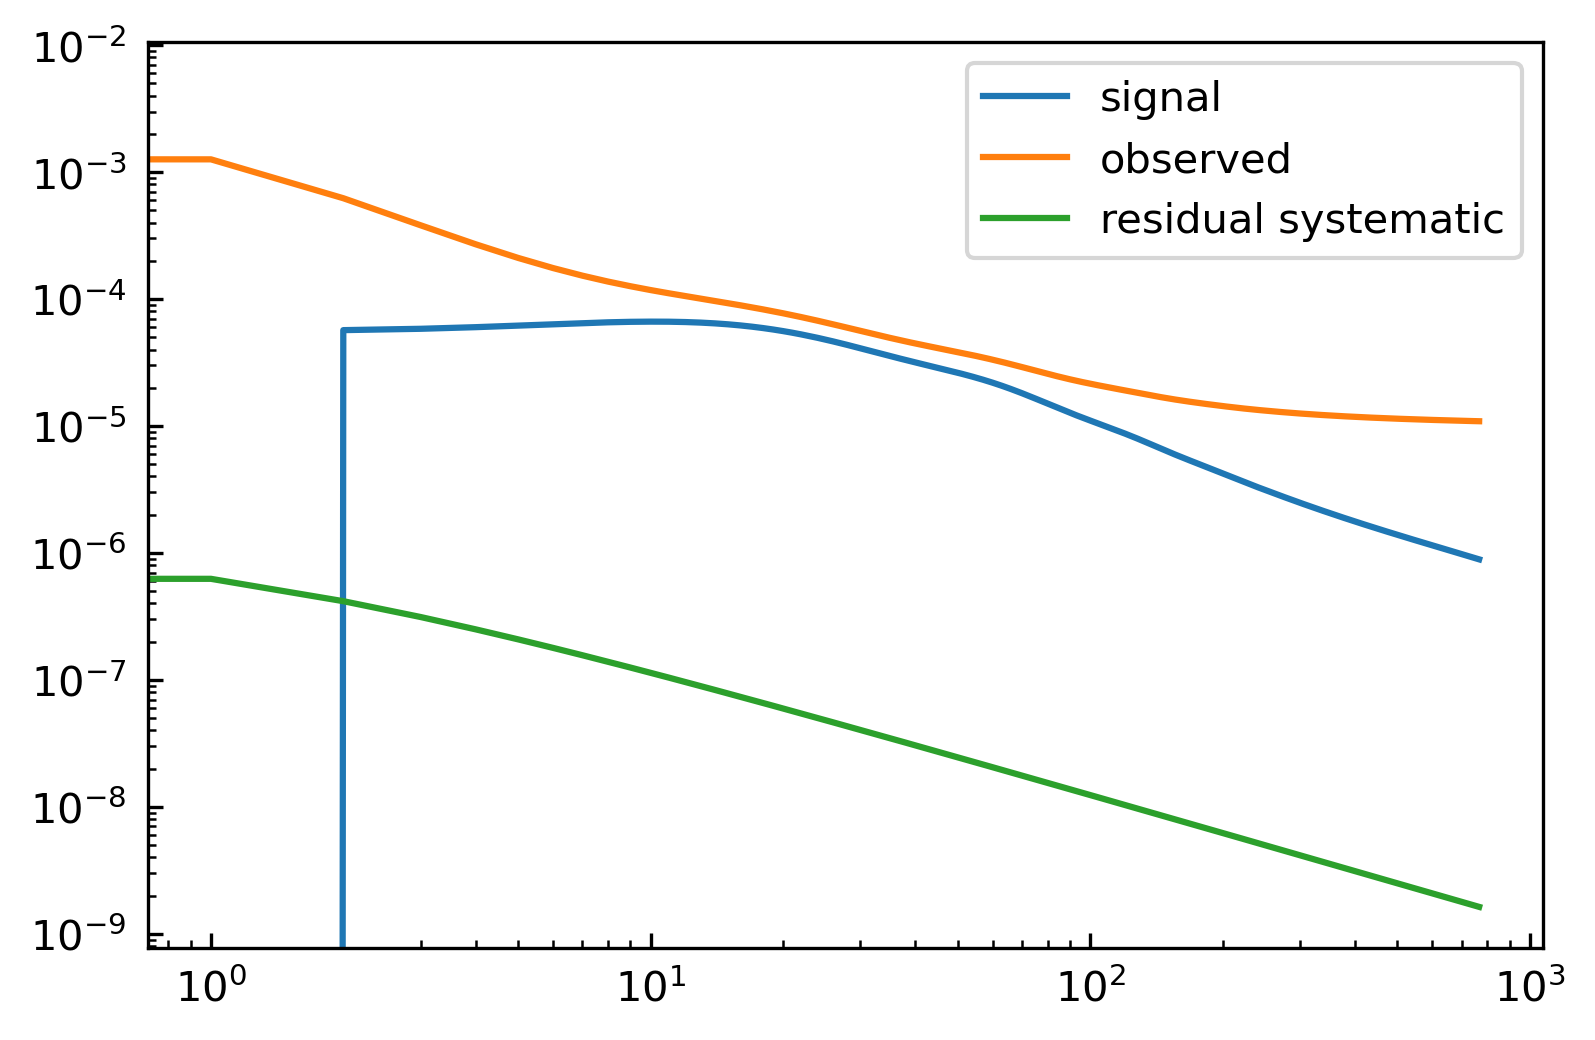

In [351]:
plt.loglog(ell,s,label='signal')
#plt.loglog(ell,t0)
plt.loglog(ell,s+t0+t2,label='observed')
plt.loglog(ell,0.05**2*t1,label='residual systematic')
plt.legend()

## Weighted average

In [10]:
salm = hp.synalm(s)
smap = hp.alm2map(salm,nside)

dalm1 = salm+talm0+talm2
dalm2 = salm+talm0+talm1

shat1 = dalm1 - np.dot(MP_alm(dalm1,talms1,ell),talms1)
shat2 = dalm2 - np.dot(MP_alm(dalm2,talms2,ell),talms2)

shatmap1 = hp.alm2map(shat1,nside)
shatmap2 = hp.alm2map(shat2,nside)

cov = np.cov(shatmap1,shatmap2)
corr = cov[1,0]/np.sqrt(np.prod(np.diag(cov)))
print(corr)

0.9999994321270902


In [11]:
np.sqrt(MSE(smap,shatmap1)), np.sqrt(MSE(smap,shatmap2))

(0.000273097783438173, 0.00020697012180290907)

In [ ]:
mse1 = []
mse2 = []
mse = []
mse_ave = []
for _ in tqdm.trange(100):
    np.random.seed(_)
    salm = hp.synalm(s)
    smap = hp.alm2map(salm,nside)

    dalm1 = salm+talm0+talm2+0.02*hp.synalm(0*ell+5e-5)
    dalm2 = salm+talm0+talm1+0.03*hp.synalm(0*ell+5e-5)

    shat1_c = dalm1 - np.dot(MP_alm(dalm1,talms1,ell),talms1)
    shat2_c = dalm2 - np.dot(MP_alm(dalm2,talms2,ell),talms2)

    shatmap1_c = hp.alm2map(shat1_c,nside)
    shatmap2_c = hp.alm2map(shat2_c,nside)

    cov = np.cov(shatmap1_c,shatmap2_c)
    corr = cov[1,0]/np.sqrt(np.prod(np.diag(cov)))

    w1_0 = 1/(cov[0,0]-1*cov[1,0])
    w2_0 = 1/(cov[1,1]-1*cov[1,0])
    w1 = w1_0/(w1_0+w2_0)
    w2 = w2_0/(w1_0+w2_0)
    shatmap_c = w1*shatmap1_c+w2*shatmap2_c
    
    mse1.append(np.sqrt(MSE(smap,shatmap1_c)))
    mse2.append(np.sqrt(MSE(smap,shatmap2_c)))
    mse.append(np.sqrt(MSE(smap,shatmap_c)))
    mse_ave.append(np.sqrt(MSE(smap,0.5*shatmap1_c+0.5*shatmap2_c)))

100%|██████████| 100/100 [00:39<00:00,  2.56it/s]


In [ ]:
print(np.mean(mse1),np.mean(mse2),np.mean(mse),np.mean(mse_ave))

0.06850929987626393 0.06851613949966848 0.048449957222713655 0.04844775094661293


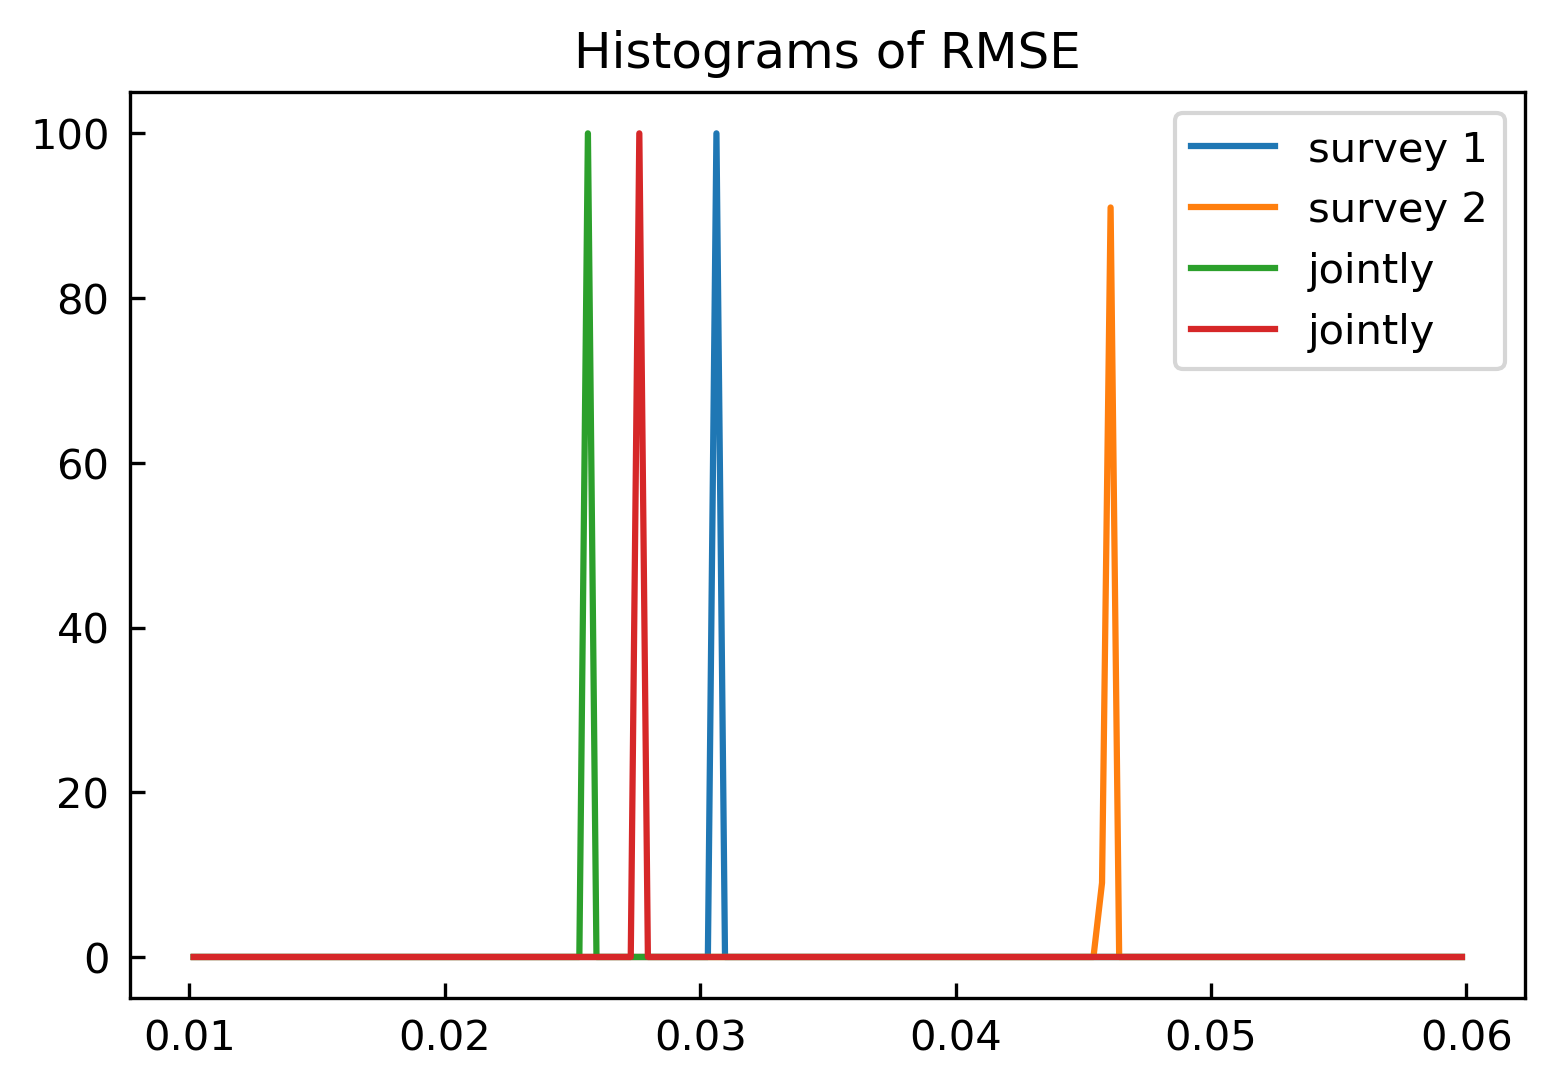

In [195]:
bins=np.linspace(0.01,0.06,150)
_ = np.histogram(mse1,bins=bins,density=False)
plt.plot(0.5*(_[1][1:]+_[1][:-1]),_[0],label='survey 1')
_ = np.histogram(mse2,bins=bins,density=False)
plt.plot(0.5*(_[1][1:]+_[1][:-1]),_[0],label='survey 2')
_ = np.histogram(mse,bins=bins,density=False)
plt.plot(0.5*(_[1][1:]+_[1][:-1]),_[0],label='jointly')
_ = np.histogram(mse_ave,bins=bins,density=False)
plt.plot(0.5*(_[1][1:]+_[1][:-1]),_[0],label='jointly')
plt.title('Histograms of RMSE')
plt.legend()

742230000

In [348]:
mse1 = []
mse2 = []
mse = []
msel = []
w1s = []
w2s = []
for _ in tqdm.trange(100):
    np.random.seed(_)
    salm = hp.synalm(s)
    smap = hp.alm2map(salm,nside)

    dalm1 = salm+talm0+talm2+hp.synalm(0*ell+5e-8)
    dalm2 = salm+talm0+talm1+hp.synalm(0*ell+5e-8)
    shat1_c = dalm1 - np.dot(MP_alm(dalm1,talms1,ell),talms1)
    shat2_c = dalm2 - np.dot(MP_alm(dalm2,talms2,ell),talms2)

    shatmap1_c = hp.alm2map(shat1_c,nside)
    shatmap2_c = hp.alm2map(shat2_c,nside)

    cov = np.cov(shatmap1_c,shatmap2_c)
    corr = cov[1,0]/np.sqrt(np.prod(np.diag(cov)))

    w1_0 = 1/(cov[0,0]-1*cov[1,0])
    w2_0 = 1/(cov[1,1]-1*cov[1,0])
    w1 = w1_0/(w1_0+w2_0)
    w2 = w2_0/(w1_0+w2_0)
    w1s.append(w1_0/(w1_0+w2_0))
    w2s.append(w2_0/(w1_0+w2_0))
    shatmap_c = w1*shatmap1_c+w2*shatmap2_c

    wmin,wmax = 0.1,0.9
    cl11 = hp.alm2cl(shat1_c)
    cl22 = hp.alm2cl(shat2_c)
    cl12 = hp.alm2cl(shat1_c,shat2_c)
    w1_0 = 1/(cl11-cl12)
    w2_0 = 1/(cl22-cl12)
    w1 = w1_0/(w1_0+w2_0)
    w2 = w2_0/(w1_0+w2_0)
    w1[w1>wmax]=wmax
    w1[w1<wmin]=wmin
    w2[w2>wmax]=wmax
    w2[w2<wmin]=wmin
    shat_l = hp.almxfl(shat1_c,w1)+hp.almxfl(shat2_c,w2)
    shatmap_l = hp.alm2map(shat_l,nside)

    mse1.append(MSE(shatmap1_c,smap))
    mse2.append(MSE(shatmap2_c,smap))
    mse.append(MSE(shatmap_c,smap))
    msel.append(MSE(shatmap_l,smap))

100%|██████████| 100/100 [00:44<00:00,  2.22it/s]


In [349]:
print(np.mean(mse1),np.mean(mse2),np.mean(mse),np.mean(mse_ave))

0.002347124165422622 0.002347359672814785 0.001173955750285198 0.04844775094661293


In [350]:
np.mean(w1s), np.mean(w2s)

(0.5000824917990665, 0.4999175082009335)

In [ ]:
(1/0.2**2)/((1/0.2**2)+(1/0.3**2)), (1/0.3**2)/((1/0.2**2)+(1/0.3**2))

(0.6923076923076923, 0.3076923076923077)

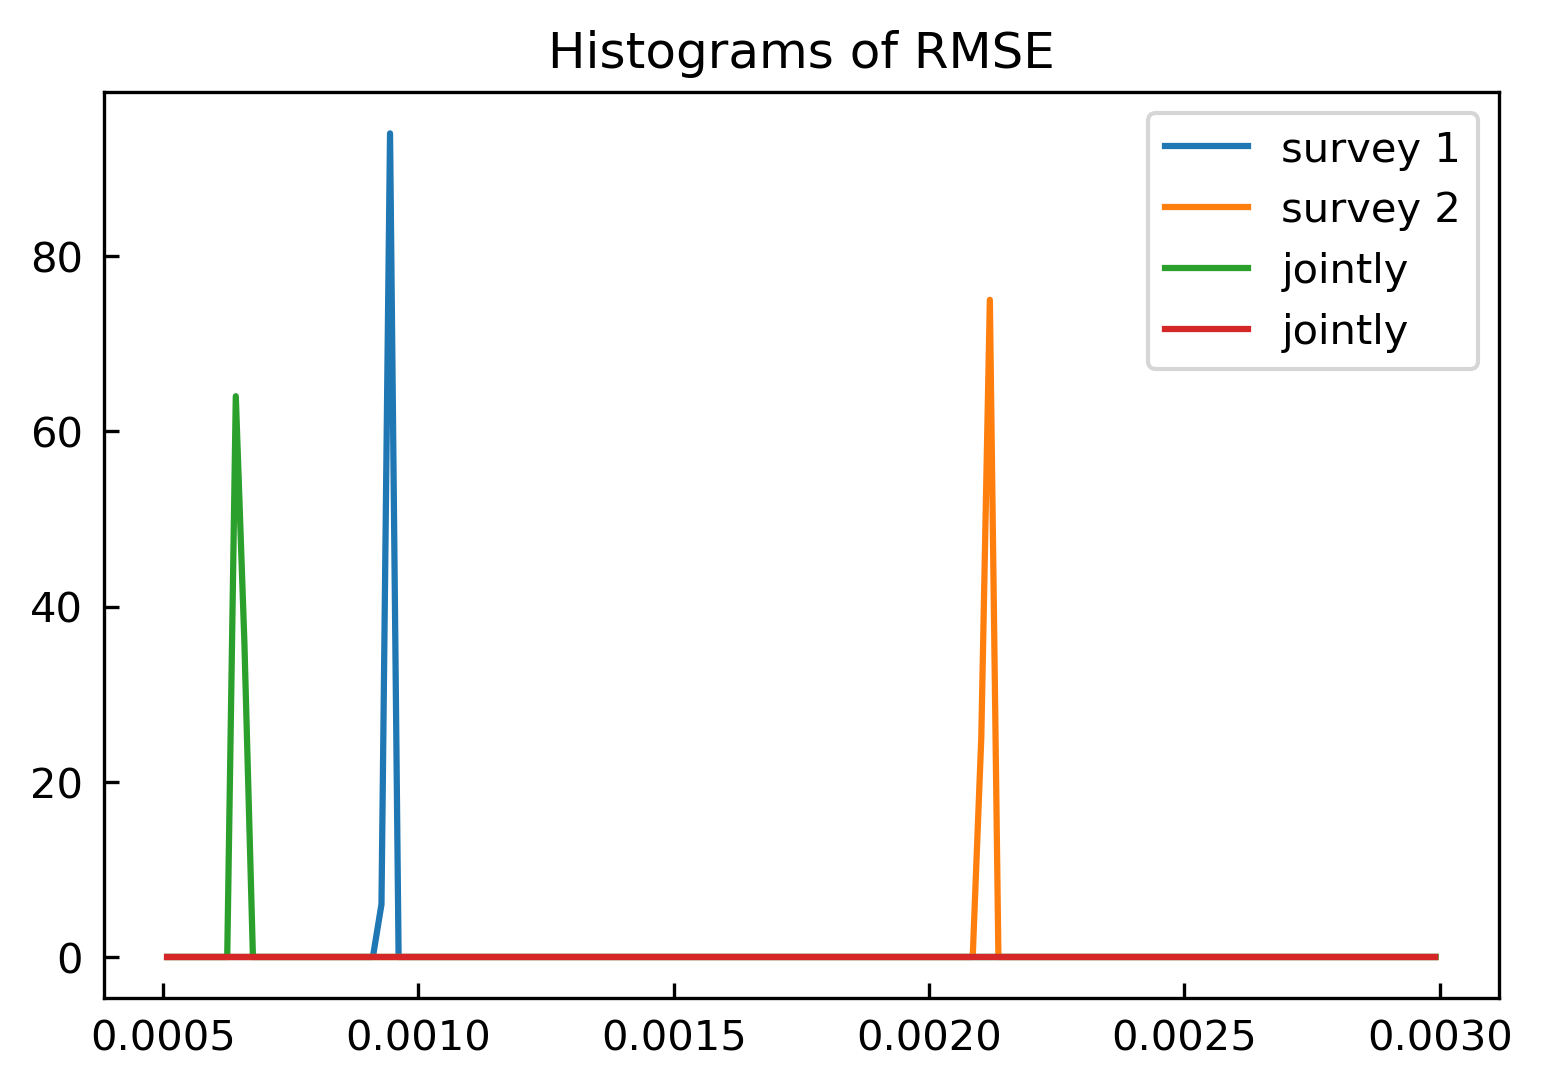

In [328]:
bins=np.linspace(0.0005,0.003,150)
_ = np.histogram(mse1,bins=bins,density=False)
plt.plot(0.5*(_[1][1:]+_[1][:-1]),_[0],label='survey 1')
_ = np.histogram(mse2,bins=bins,density=False)
plt.plot(0.5*(_[1][1:]+_[1][:-1]),_[0],label='survey 2')
_ = np.histogram(mse,bins=bins,density=False)
plt.plot(0.5*(_[1][1:]+_[1][:-1]),_[0],label='jointly')
_ = np.histogram(mse_ave,bins=bins,density=False)
plt.plot(0.5*(_[1][1:]+_[1][:-1]),_[0],label='jointly')
plt.title('Histograms of RMSE')
plt.legend()